# Tugas Besar Pembelajaran Mesin 2

#### Pustaka Terkait

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
import time
import random
import matplotlib.pyplot as plt

## 1.a. Create a Classifier 

#### Deskripsi Algoritma

Inisialisasi model neural network ini menggunakan langkah-langkah sebagai berikut:
1. Jumlah node setiap layer (parameter sizes) dispesifikasikan.
2. Bias dan weight untuk setiap layer setelah layer pertama dihitung secara acak.

Proses fitting model sebelumnya menggunakan algoritma sebagai berikut:
1. Dalam fungsi fit dibutuhkan parameter jumlah data training (training_data), jumlah epoch (epochs), ukuran mini-batch (mini_batch_size), dan learning rate (learning_rate). Momentum (parameter momentum) jika diinginkan juga dapat dispesifikasikan. Data validasi (parameter validation_data) dapat dispesifikasikan secara langsung atau didapatkan dari training data jika parameter validation_split dispesifikasikan.
2. Training data dibagi-bagi menjadi mini-batch berdasarkan ukuran mini-batch.
3. Weight dan bias baru dihitung per mini-batch menggunakan fungsi update_mini_batch yang mengimplementasikan stochastic gradient. Dalam implementasi stochastic gradient digunakan fungsi backpropagation.
4. Lakukan langkah 3 untuk setiap mini-batch
5. Hitung akurasi dan loss training menggunakan fungsi evaluate dengan input mini-batch pertama. Fungsi evaluate menghasilkan nilai akurasi dan loss berdasarkan hasil feed-forward sigmoid (fungsi feed_forward). Hasil feed-forward setiap data jika lebih dari 0.5 akan menghasilkan 1, jika tidak menghasilkan 0. Akurasi dihitung dari rasio jumlah data setelah feed-forward yang sama dengan labelnya dengan jumlah seluruh data. Loss dihitung dari selisih kuadrat antara label dengan hasil data setelah feed-forward setiap data dibagi dengan jumlah semua data.
6. Hitung akurasi dan loss validasi menggunakan fungsi evaluate dengan input validation_data.
7. Lakukan langkah 2-6 untuk setiap epoch

Untuk melakukan prediksi dapat digunakan fungsi predict dengan input test_data. Dalam fungsi ini setiap test_data akan dilakukan feed-forward seperti pada fungsi evaluate.

#### Source Code Program

In [2]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.rand(y, 1) for y in sizes[1:]]
        self.weights = [np.random.rand(y, x) for x,y in zip(sizes[:-1], sizes[1:])]
        self.history = d = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    def feed_forward(self, activation):
        for bias, weight in zip(self.biases, self.weights):
            activation = sigmoid(np.dot(weight, activation) + bias.transpose()[0])
        return activation
    
    def fit(self, training_data, epochs, mini_batch_size, learning_rate,
            momentum=0, validation_data=None, validation_split=0.0, verbose=1):
        if validation_split != 0.0 and not validation_data :
            training_data, validation_data = train_test_split(training_data, test_size=validation_split, random_state=42)
        n_training = len(training_data)
        if validation_data or validation_split != 0.0: 
            n_validation = len(validation_data)
            if verbose != 0:
                print("Train on {} samples, validate on {} samples".format(n_training, n_validation))
        for epoch in range(epochs):
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n_training, mini_batch_size)]
            previous_weights = self.weights
            previous_biases =self.biases
            first = True
            for mini_batch in mini_batches:
                if first: previous_weights, previous_biases = self.weights, self.biases
                start = time.time()
                previous_weights, previous_biases = self.update_mini_batch(mini_batch, 
                                                                           learning_rate,
                                                                           momentum, 
                                                                           previous_weights, 
                                                                           previous_biases)
                end = time.time() - start
            if validation_data or validation_split != 0:
                training_accuracy, training_loss = self.evaluate(mini_batches[0])
                validation_accuracy, validation_loss = self.evaluate(validation_data)
                self.history['acc'].append(training_accuracy)
                self.history['val_acc'].append(validation_accuracy)
                self.history['loss'].append(training_loss)
                self.history['val_loss'].append(validation_loss)
                if verbose == 1 :
                    print("Epoch {}/{} : {} s - loss: {} - acc: {} - val_loss: {} - val_acc: {}".format(epoch + 1, 
                                                                                                        epochs,
                                                                                                        end,
                                                                                                        training_loss,
                                                                                                        training_accuracy,
                                                                                                        validation_loss,
                                                                                                        validation_accuracy))
                elif verbose == 2 :
                    print("Epoch {} complete.".format(epoch + 1))
            else :
                if verbose != 0:
                    print("Epoch {} complete.".format(epoch + 1))
        
    def update_mini_batch(self, mini_batch, learning_rate, momentum, previous_weights, previous_biases):
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        for x, y in mini_batch:
            delta_nabla_bias, delta_nabla_weights = self.backpropagation(x, y)
            nabla_biases = [nb + dnb for nb, dnb in zip(nabla_biases, delta_nabla_bias)]
            nabla_weights = [nw + dnw for nw, dnw in zip(nabla_weights, delta_nabla_weights)]
        temp_weights = self.weights
        temp_biases = self.biases
        self.weights = [w + momentum * pw + (learning_rate/len(mini_batch)) * nw 
                        for w, nw, pw in zip(self.weights, nabla_weights, previous_weights)]
        self.biases = [b + momentum * pb + (learning_rate/len(mini_batch)) * nb 
                       for b, nb, pb in zip(self.biases, nabla_biases, previous_biases)]
        return (temp_weights, temp_biases)
        
    def backpropagation(self, x, y):
        nabla_bias = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = x
        activations = [x]
        z_vectors = []
        
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, activation) + bias.transpose()[0]
            z_vectors.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(z_vectors[-1])
        nabla_bias[-1] = delta
        delta_newaxis = delta[:, np.newaxis]
        m = len(activations[-2])
        activations_newaxis = activations[-2][:, np.newaxis].reshape(1, m)
        nabla_weights[-1] = np.dot(delta_newaxis, activations_newaxis)
        
        for layer in range(2, self.num_layers):
            z = z_vectors[-layer]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            nabla_bias[-layer] = delta
            delta_newaxis = delta[:, np.newaxis]
            m = len(activations[-layer-1].transpose())
            activations_newaxis = activations[-layer-1].transpose()[:, np.newaxis].reshape(1, m)
            nabla_weights[-layer] = np.dot(delta_newaxis, activations_newaxis)
        
        return (nabla_bias, nabla_weights)
    
    def evaluate(self, test_data):
        test_results = [(1 if self.feed_forward(x) * 2 >= 1 else 0, y) for x, y in test_data]
        accuracy = sum(int(x == y) for x, y in test_results)/len(test_results)
        loss = sum(pow(int(y - x), 2) for x, y in test_results)/len(test_results)
        return accuracy, loss
    
    def predict(self, test_data):
        test_results = [1 if self.feed_forward(x) * 2 >= 1 else 0 for x, y in test_data]
        return (test_results)
    
    def cost_derivative(self, output_activations, y):
        return np.squeeze(y - output_activations)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

## 1.b.1 Explorasi Keras 

#### Deskripsi Algoritma

Pembelajaran akan menggunakan kakas keras dengan model <i>sequential</i> dan lapisan <i>dense</i> .Model akan memakai input layer sebanyak 1 neuron dengan bentuk input 4 sesuai jumlah attribute data latih, kemudian dengan 3 hidden layer masing-masing 2 neuron kemudian 3 neuron, dan 4 neuron dan 1 output layer dengan 1 neuron. Optimizer yang dipakai adalah SGD, dengan perhitungan loss dengan Mean Squared Error, dan Metrics Accuracy. 

#### Source Code Program

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [4]:
network = Sequential()
network.add(Dense(4, activation='sigmoid', input_shape=(4,)))
network.add(Dense(5, activation='sigmoid'))
network.add(Dense(5, activation='sigmoid'))
network.add(Dense(1, activation='sigmoid'))

In [5]:
network.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [6]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


## 1.b.2 Eksperimen Data Categorization Framework

#### Persiapan Data

Hal pertama yang kami lakukan adalah menggunakan data latih Weather Categorization dari WEKA. 

In [7]:
weather_df = pd.read_csv('dataset/weather.csv')

weather_df

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes
5,rainy,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rainy,75,80,False,yes


Dapat dilihat data latih terdiri dari data numerik dan data kategorikal. Diperlukan preprocessing dengan kakas scikit-learn yaitu LabelEncoder sebagai berikut.

In [8]:
label_encoder = LabelEncoder()
weather_df['outlook'] = label_encoder.fit_transform(weather_df.outlook)
weather_df['windy'] = label_encoder.fit_transform(weather_df.windy)
weather_df['play'] = label_encoder.fit_transform(weather_df.play)

In [9]:
weather_df

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1
5,1,65,70,1,0
6,0,64,65,1,1
7,2,72,95,0,0
8,2,69,70,0,1
9,1,75,80,0,1


In [10]:
X_weather = weather_df.iloc[:,:4].values
X_weather

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1],
       [ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [11]:
y_weather = weather_df.play.values
y_weather

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Kemudian, setelah kami menjadikan data latih tersebut numerik, kami melakukan pemisahan sebagian data latih (10%) menjadi data uji dengan proporsi.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_weather, y_weather, test_size=0.1,shuffle=False)

In [13]:
X_train

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1]])

In [14]:
X_test

array([[ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [15]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [16]:
y_test

array([1, 0])

In [17]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

<b> Batch = 1 </b>

##### Classifier Sendiri

In [18]:
start = time.time()

In [19]:
neural_network1 = Network([4, 10, 8, 1])
neural_network1.fit(train_data, 500, 1, 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/500 : 0.00012540817260742188 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/500 : 0.0001246929168701172 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/500 : 0.00011134147644042969 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/500 : 0.00012612342834472656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/500 : 0.00013828277587890625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/500 : 0.0001270771026611328 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/500 : 0.000125885009765625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/500 : 0.000125885009765625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/500 : 0.0001266002655029297 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/500 : 0.00012612342834472656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/500 : 0.0001254081726074

Epoch 114/500 : 0.0001614093780517578 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 115/500 : 0.00011754035949707031 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 116/500 : 0.00012946128845214844 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 117/500 : 0.00012683868408203125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 118/500 : 0.00012683868408203125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 119/500 : 0.00011181831359863281 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 120/500 : 0.00012755393981933594 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 121/500 : 0.00011420249938964844 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 122/500 : 0.0001277923583984375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 123/500 : 0.0003142356872558594 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 124/500 : 0.00011610984802246094 s - loss: 1.0 

Epoch 228/500 : 0.0001518726348876953 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 229/500 : 0.00011086463928222656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 230/500 : 0.00012731552124023438 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 231/500 : 0.00012612342834472656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 232/500 : 0.00012540817260742188 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 233/500 : 0.0001251697540283203 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 234/500 : 0.0001251697540283203 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 235/500 : 0.00012612342834472656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 236/500 : 0.00012564659118652344 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 237/500 : 0.0001251697540283203 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 238/500 : 0.000125885009765625 s - loss: 1.0 - a

Epoch 350/500 : 0.0001277923583984375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 351/500 : 0.00013446807861328125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 352/500 : 0.00021219253540039062 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 353/500 : 0.00011563301086425781 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 354/500 : 0.0001277923583984375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 355/500 : 0.00011897087097167969 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 356/500 : 0.00011920928955078125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 357/500 : 0.0001125335693359375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 358/500 : 0.0001266002655029297 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 359/500 : 0.00011205673217773438 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 360/500 : 0.00012731552124023438 s - loss: 1.0 -

Epoch 470/500 : 0.00012612342834472656 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 471/500 : 0.00012636184692382812 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 472/500 : 0.00012683868408203125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 473/500 : 0.0001304149627685547 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 474/500 : 0.0001289844512939453 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 475/500 : 0.0003383159637451172 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 476/500 : 0.00013184547424316406 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 477/500 : 0.000125885009765625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 478/500 : 0.00012540817260742188 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 479/500 : 0.0001251697540283203 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 480/500 : 0.0001347064971923828 s - loss: 1.0 - ac

In [20]:
end = time.time() - start

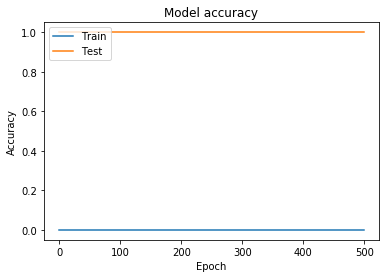

In [21]:
plt.plot(neural_network1.history['acc'])
plt.plot(neural_network1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

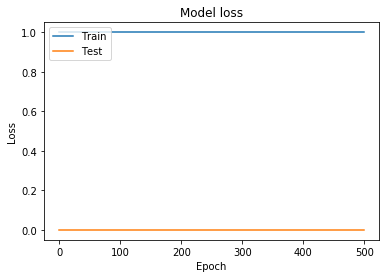

In [22]:
plt.plot(neural_network1.history['loss'])
plt.plot(neural_network1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
accuracy1, loss1 = neural_network1.evaluate(test_data)

In [24]:
print("Loss: {} %".format(loss1*100.0))
print("Accuracy {} %".format(accuracy1*100.0))
print("Time: {} ms".format(end))

Loss: 50.0 %
Accuracy 50.0 %
Time: 0.9927120208740234 ms


##### Keras Model

Reinitialisasi model keras untuk eksperimen pertama.

In [25]:
network1 = Sequential([
    Dense(4, input_shape=(4,)),
    Dense(10, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [26]:
network1.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [27]:
network1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________


In [28]:
start = time.time()

In [29]:
history1 = network1.fit(X_train, y_train, epochs=500, batch_size=1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/500
10/10 [==============================] - 0s 18ms/step - loss: 0.2603 - acc: 0.6000 - val_loss: 0.0732 - val_acc: 1.0000
Epoch 2/500
10/10 [==============================] - 0s 856us/step - loss: 0.2582 - acc: 0.6000 - val_loss: 0.0755 - val_acc: 1.0000
Epoch 3/500
10/10 [==============================] - 0s 943us/step - loss: 0.2562 - acc: 0.6000 - val_loss: 0.0784 - val_acc: 1.0000
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2547 - acc: 0.6000 - val_loss: 0.0810 - val_acc: 1.0000
Epoch 5/500
10/10 [==============================] - 0s 720us/step - loss: 0.2538 - acc: 0.6000 - val_loss: 0.0835 - val_acc: 1.0000
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2530 - acc: 0.6000 - val_loss: 0.0857 - val_acc: 1.0000
Epoch 7/500
10/10 [==============================] - 0s 819us/step - loss: 0.2523 - acc: 0.6000 - val_loss: 0.0879 - val_acc: 1.0000
Epoch 8/500
10/10 [============

Epoch 62/500
10/10 [==============================] - 0s 822us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1514 - val_acc: 1.0000
Epoch 63/500
10/10 [==============================] - 0s 737us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1517 - val_acc: 1.0000
Epoch 64/500
10/10 [==============================] - 0s 899us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1521 - val_acc: 1.0000
Epoch 65/500
10/10 [==============================] - 0s 818us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1524 - val_acc: 1.0000
Epoch 66/500
10/10 [==============================] - 0s 790us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1528 - val_acc: 1.0000
Epoch 67/500
10/10 [==============================] - 0s 743us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1531 - val_acc: 1.0000
Epoch 68/500
10/10 [==============================] - 0s 960us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1533 - val_acc: 1.0000
Epoch 69/500
10/10 [==============================] - 0s 881us

10/10 [==============================] - 0s 905us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1594 - val_acc: 1.0000
Epoch 124/500
10/10 [==============================] - 0s 810us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1594 - val_acc: 1.0000
Epoch 125/500
10/10 [==============================] - 0s 845us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1593 - val_acc: 1.0000
Epoch 126/500
10/10 [==============================] - 0s 865us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1592 - val_acc: 1.0000
Epoch 127/500
10/10 [==============================] - 0s 911us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1592 - val_acc: 1.0000
Epoch 128/500
10/10 [==============================] - 0s 867us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1593 - val_acc: 1.0000
Epoch 129/500
10/10 [==============================] - 0s 865us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1593 - val_acc: 1.0000
Epoch 130/500
10/10 [==============================] - 0s 939us/step 

10/10 [==============================] - 0s 970us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 184/500
10/10 [==============================] - 0s 770us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 185/500
10/10 [==============================] - 0s 809us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 186/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 187/500
10/10 [==============================] - 0s 813us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 188/500
10/10 [==============================] - 0s 865us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 189/500
10/10 [==============================] - 0s 865us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 190/500
10/10 [==============================] - 0s 849us/step - 

Epoch 244/500
10/10 [==============================] - 0s 848us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 245/500
10/10 [==============================] - 0s 790us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 246/500
10/10 [==============================] - 0s 794us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 247/500
10/10 [==============================] - 0s 787us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 248/500
10/10 [==============================] - 0s 896us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 249/500
10/10 [==============================] - 0s 887us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 250/500
10/10 [==============================] - 0s 810us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 251/500
10/10 [==============================] - 

10/10 [==============================] - 0s 1ms/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 305/500
10/10 [==============================] - 0s 836us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 306/500
10/10 [==============================] - 0s 878us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 307/500
10/10 [==============================] - 0s 820us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1600 - val_acc: 1.0000
Epoch 308/500
10/10 [==============================] - 0s 910us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1600 - val_acc: 1.0000
Epoch 309/500
10/10 [==============================] - 0s 837us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 310/500
10/10 [==============================] - 0s 745us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1600 - val_acc: 1.0000
Epoch 311/500
10/10 [==============================] - 0s 1ms/step - lo

Epoch 365/500
10/10 [==============================] - 0s 804us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 366/500
10/10 [==============================] - 0s 891us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 367/500
10/10 [==============================] - 0s 801us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 368/500
10/10 [==============================] - 0s 952us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 369/500
10/10 [==============================] - 0s 845us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 370/500
10/10 [==============================] - 0s 834us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 371/500
10/10 [==============================] - 0s 938us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 372/500
10/10 [==============================] - 

Epoch 426/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1606 - val_acc: 1.0000
Epoch 427/500
10/10 [==============================] - 0s 883us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 428/500
10/10 [==============================] - 0s 984us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 429/500
10/10 [==============================] - 0s 908us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1606 - val_acc: 1.0000
Epoch 430/500
10/10 [==============================] - 0s 898us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 431/500
10/10 [==============================] - 0s 852us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 432/500
10/10 [==============================] - 0s 881us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 433/500
10/10 [==============================] - 0s

Epoch 487/500
10/10 [==============================] - 0s 861us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 488/500
10/10 [==============================] - 0s 828us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 489/500
10/10 [==============================] - 0s 897us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 490/500
10/10 [==============================] - 0s 794us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1604 - val_acc: 1.0000
Epoch 491/500
10/10 [==============================] - 0s 945us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1604 - val_acc: 1.0000
Epoch 492/500
10/10 [==============================] - 0s 797us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1603 - val_acc: 1.0000
Epoch 493/500
10/10 [==============================] - 0s 940us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 494/500
10/10 [==============================] - 

In [30]:
end = time.time() - start

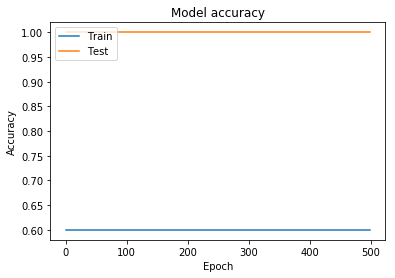

In [31]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

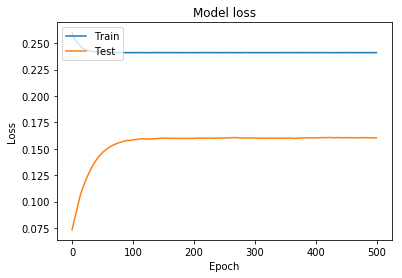

In [32]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [33]:
score1 = network1.evaluate(X_test, y_test, batch_size=1)

2/2 [==============================] - 0s 1ms/step


In [34]:
print("Loss: {} %".format(score1[0]*100.0))
print("Accuracy {} %".format(score1[1]*100.0))
print("Time: {} ms".format(end))

Loss: 26.01824328303337 %
Accuracy 50.0 %
Time: 5.225123167037964 ms


<b>Batch Size = Jumlah Data Latih</b>

##### Classifier Sendiri

In [35]:
start = time.time()

In [ ]:
neural_network2 = Network([4, 10, 8, 1])
neural_network2.fit(train_data, 500, len(X_train), 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/500 : 0.0015017986297607422 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/500 : 0.0010921955108642578 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/500 : 0.0010199546813964844 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/500 : 0.0010116100311279297 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/500 : 0.0009989738464355469 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/500 : 0.0010149478912353516 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/500 : 0.0010094642639160156 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/500 : 0.0009961128234863281 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/500 : 0.0011184215545654297 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/500 : 0.0010066032409667969 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/500 : 0.001256704330444336 

In [ ]:
end = time.time() - start

In [ ]:
plt.plot(neural_network2.history['acc'])
plt.plot(neural_network2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(neural_network2.history['acc'])
plt.plot(neural_network2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
accuracy2, loss2 = neural_network2.evaluate(test_data)

In [ ]:
print("Loss: {} %".format(loss2*100.0))
print("Accuracy {} %".format(accuracy2*100.0))
print("Time: {} ms".format(end))

##### Keras Model

Reinitialisasi model keras untuk eksperimen kedua.

In [ ]:
network2 = Sequential([
    Dense(4, input_shape=(4,)),
    Dense(10, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [ ]:
network2.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [ ]:
network2.summary()

In [ ]:
start = time.time()

In [ ]:
history2 = network2.fit(X_train, y_train, epochs=500, batch_size=len(X_train), validation_split=0.1)

In [ ]:
end = time.time() - start

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
score2 = network2.evaluate(X_test, y_test, batch_size=len(X_train))

In [ ]:
print("Loss: {} %".format(score2[0]*100.0))
print("Accuracy {} %".format(score2[1]*100.0))
print("Time: {} ms".format(end))

### Analisis Eksperimen

### Pembagian Kerja